In [181]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Scaling and pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV

#Reports
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

In [134]:
data = pd.read_csv('../preprocessed_data/p_data')
data

,age,gender,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,family_history_diabetes,hypertension_history,cardiovascular_history,bmi,...,alcohol_consumption_per_week_1,alcohol_consumption_per_week_2,alcohol_consumption_per_week_3,alcohol_consumption_per_week_4,alcohol_consumption_per_week_5,alcohol_consumption_per_week_6,alcohol_consumption_per_week_7,alcohol_consumption_per_week_8,alcohol_consumption_per_week_9,alcohol_consumption_per_week_10
0,58.0,1.0,14.662878,5.7,7.9,7.9,0.0,0.0,0.0,30.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,48.0,0.0,11.958261,6.7,6.5,8.7,0.0,0.0,0.0,23.1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,60.0,1.0,7.549834,6.4,9.8,8.1,1.0,0.0,0.0,22.2,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,74.0,0.0,7.000000,3.4,6.6,5.2,0.0,0.0,0.0,26.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,46.0,1.0,10.440307,7.2,7.4,5.0,0.0,0.0,0.0,21.2,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,46.0,1.0,11.661904,8.3,6.4,4.5,0.0,0.0,0.0,29.8,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99996,41.0,0.0,8.717798,8.8,6.8,4.8,0.0,0.0,0.0,26.5,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99997,57.0,0.0,11.000000,9.9,5.0,6.1,0.0,0.0,1.0,25.6,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
99998,47.0,0.0,7.211103,5.9,6.7,0.5,0.0,1.0,0.0,26.8,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Scaling Methods 

Below are the most commonly used scaling techniques in machine learning, along with their formulas and short descriptions.

 **1. StandardScaler**

$$X_{\text{scaled}} = \frac{X - \text{mean}}{\text{std}}$$

 **2. MinMaxScaler**
 
$$X_{\text{scaled}} = \frac{X - X_{\min}}{X_{\max} - X_{\min}}$$

 **3. RobustScaler**
 
$$X_{\text{scaled}} = \frac{X - median}{IQR}$$

$$IQR = Q3 - Q1$$

 **4. MaxAbsScaler**
 
$$X_{\text{scaled}} = \frac{X}{\max(|X|)}$$

We use `StandardScaler` because:

- It is the most appropriate method for **models sensitive to feature scale**, such as `Logistic Regression`, `SVM`, `KNN`.  
- It keeps the **distribution shape** similar but centers it at 0 with a variance of 1.  
- It prevents features with large numeric ranges from dominating the model training.  
- It works especially well after prior preprocessing steps like **log1p** and **outlier clipping**.

**In our case, StandardScaler is the correct choice because the model (Logistic Regression) requires features on a comparable scale, and we already handled outliers in preprocessing.**


### Defining Pipelines for Each Model, split the dataset, fit and score the model

---

In [135]:
lr_model = Pipeline([
    ('scale', StandardScaler()),
    ('lr_model', LogisticRegression())
])

In [136]:
svm_model = Pipeline([
    ('scale', StandardScaler()),
    ('model', SVC(probability=True))
])

In [137]:
knn_model = Pipeline([
    ('scale', StandardScaler()),
    ('model', KNeighborsClassifier())
])

In [138]:
rf_model = RandomForestClassifier()

In [139]:
gb_model = GradientBoostingClassifier()

In [140]:
models = {
    "Logistic Regression": lr_model,
    "SVM": svm_model,
    "KNN": knn_model,
    "Random Forest": rf_model,
    "Gradient Boosting": gb_model
}

In [141]:
X = data.drop(columns='target')
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [142]:
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    results[name] = score

results

{'Logistic Regression': 0.99925,
 'SVM': 0.99905,
 'KNN': 0.99675,
 'Random Forest': 0.9997,
 'Gradient Boosting': 0.9997}

In [143]:
model_result = pd.DataFrame(
    results.items(),
    columns=['Model', 'Score']
)
descending_ordered_model_result = model_result.sort_values(ascending=False, by='Score')

### Model Hyperparameter Optimization

---

In [144]:
param_grid_lr = {
    'lr_model__max_iter': [10, 100, 500, 700, 1000] 
}

grid_lr = GridSearchCV(
    estimator=lr_model,
    param_grid=param_grid_lr,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_lr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('lr_model', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'lr_model__max_iter': [10, 100, 500, 700, 1000]},
             scoring='roc_auc')

In [146]:
cv_results = pd.DataFrame(grid_lr.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr_model__max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.564739,0.104923,0.041482,0.005879,10,{'lr_model__max_iter': 10},0.999995,0.999998,0.999998,0.999998,0.999999,0.999998,1.195904e-06,5
1,0.907832,0.063028,0.041001,0.007860,100,{'lr_model__max_iter': 100},0.999996,0.999998,0.999998,0.999998,0.999999,0.999998,8.011736e-07,1
2,0.879029,0.143829,0.033094,0.011122,500,{'lr_model__max_iter': 500},0.999996,0.999998,0.999998,0.999998,0.999999,0.999998,8.011736e-07,1
3,0.855924,0.162568,0.029691,0.010585,700,{'lr_model__max_iter': 700},0.999996,0.999998,0.999998,0.999998,0.999999,0.999998,8.011736e-07,1
4,0.755700,0.141862,0.016933,0.004506,1000,{'lr_model__max_iter': 1000},0.999996,0.999998,0.999998,0.999998,0.999999,0.999998,8.011736e-07,1


In [160]:
y_pred = lr_model.predict(X_test)

In [164]:

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8000
         1.0       1.00      1.00      1.00     12000

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000



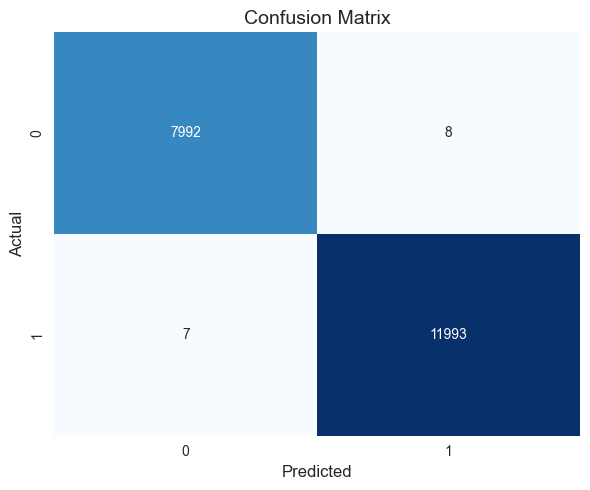

In [188]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={"size": 10})
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.tight_layout()
plt.show()

<Figure size 700x600 with 0 Axes>

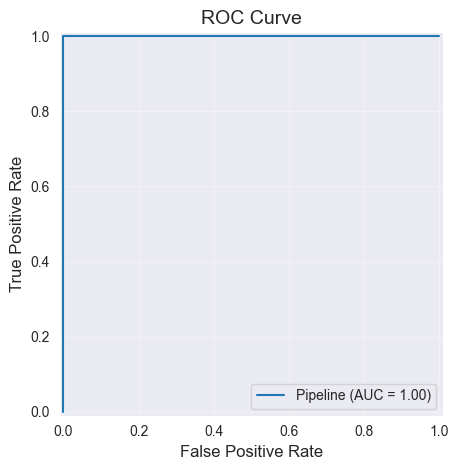

In [187]:
plt.figure(figsize=(7, 6))
RocCurveDisplay.from_estimator(lr_model, X_test, y_test)

plt.title("ROC Curve", fontsize=14)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()